## Goals

- better understand the use of unsupervised learning techniques
- use a variety of methods and models
- explore hyperparamater tuning

## The Dataset

Here I will use the [Google Play Store dataset](https://www.kaggle.com/lava18/google-play-store-apps) from Kaggle.

### Import Libraries and Define Functions

In [23]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics

In [2]:
def print_nulls(df):
    out = pd.Series({'Column': 'Percentage of nulls', '-----' : '-----'}
                   ).append(df.isnull().sum()*100/df.isnull().isnull().count())
   
    return out

In [3]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column, size='xx-large')
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 90th percentile
    plt.show()

### Load the dataset

In [4]:
df = pd.read_csv(r'archive/googleplaystore.csv')

In [5]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [6]:
print_nulls(df)

Column            Percentage of nulls
-----                           -----
App                                 0
Category                            0
Rating                        13.5965
Reviews                             0
Size                                0
Installs                            0
Type                       0.00922424
Price                               0
Content Rating             0.00922424
Genres                              0
Last Updated                        0
Current Ver                 0.0737939
Android Ver                 0.0276727
dtype: object

In [7]:
# Imputing the reviews/predicting the reviews of these 
# nulls is a problem for another day

df = df.dropna()

# Make column names lowercase for ease and consistency
df.columns= df.columns.str.lower()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app             9360 non-null   object 
 1   category        9360 non-null   object 
 2   rating          9360 non-null   float64
 3   reviews         9360 non-null   object 
 4   size            9360 non-null   object 
 5   installs        9360 non-null   object 
 6   type            9360 non-null   object 
 7   price           9360 non-null   object 
 8   content rating  9360 non-null   object 
 9   genres          9360 non-null   object 
 10  last updated    9360 non-null   object 
 11  current ver     9360 non-null   object 
 12  android ver     9360 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


In [9]:
# Some columns can be changed to numerical

In [10]:
# not trying to save any data today just get right to modeling
index = df[df['size'] == 'Varies with device'].index

df.drop(index, inplace=True)

In [11]:
# reviews
df['reviews'] = df['reviews'].apply(lambda x: int(x))


# installs
df['installs'] = df['installs'].apply(lambda x: x.replace('+', '') 
                                      if '+' in str(x) else x)
df['installs'] = df['installs'].apply(lambda x: x.replace(',', '') 
                                      if ',' in str(x) else x)
df['installs'] = df['installs'].apply(lambda x: float(x))


# price
df['price'] = df['price'].apply(lambda x: str(x).replace('$', '') 
                                if '$' in str(x) else str(x))
df['price'] = df['price'].apply(lambda x: float(x))


# size
df['size'] = df['size'].apply(lambda x: str(x).replace('M', '') 
                              if 'M' in str(x) else x)
df['size'] = df['size'].apply(lambda x: str(x).replace(',', '') 
                              if ',' in str(x) else x)
df['size'] = df['size'].apply(lambda x: float(str(x).replace('k', '')
                                             ) / 1000 if 'k' in str(x) else x)
df['size'] = df['size'].apply(lambda x: float(x))

In [12]:
index = df[df['android ver'] == 'Varies with device'].index

df.drop(index, inplace=True)

df['android ver'] = df['android ver'].apply(lambda x: float(str(x)[:3]))

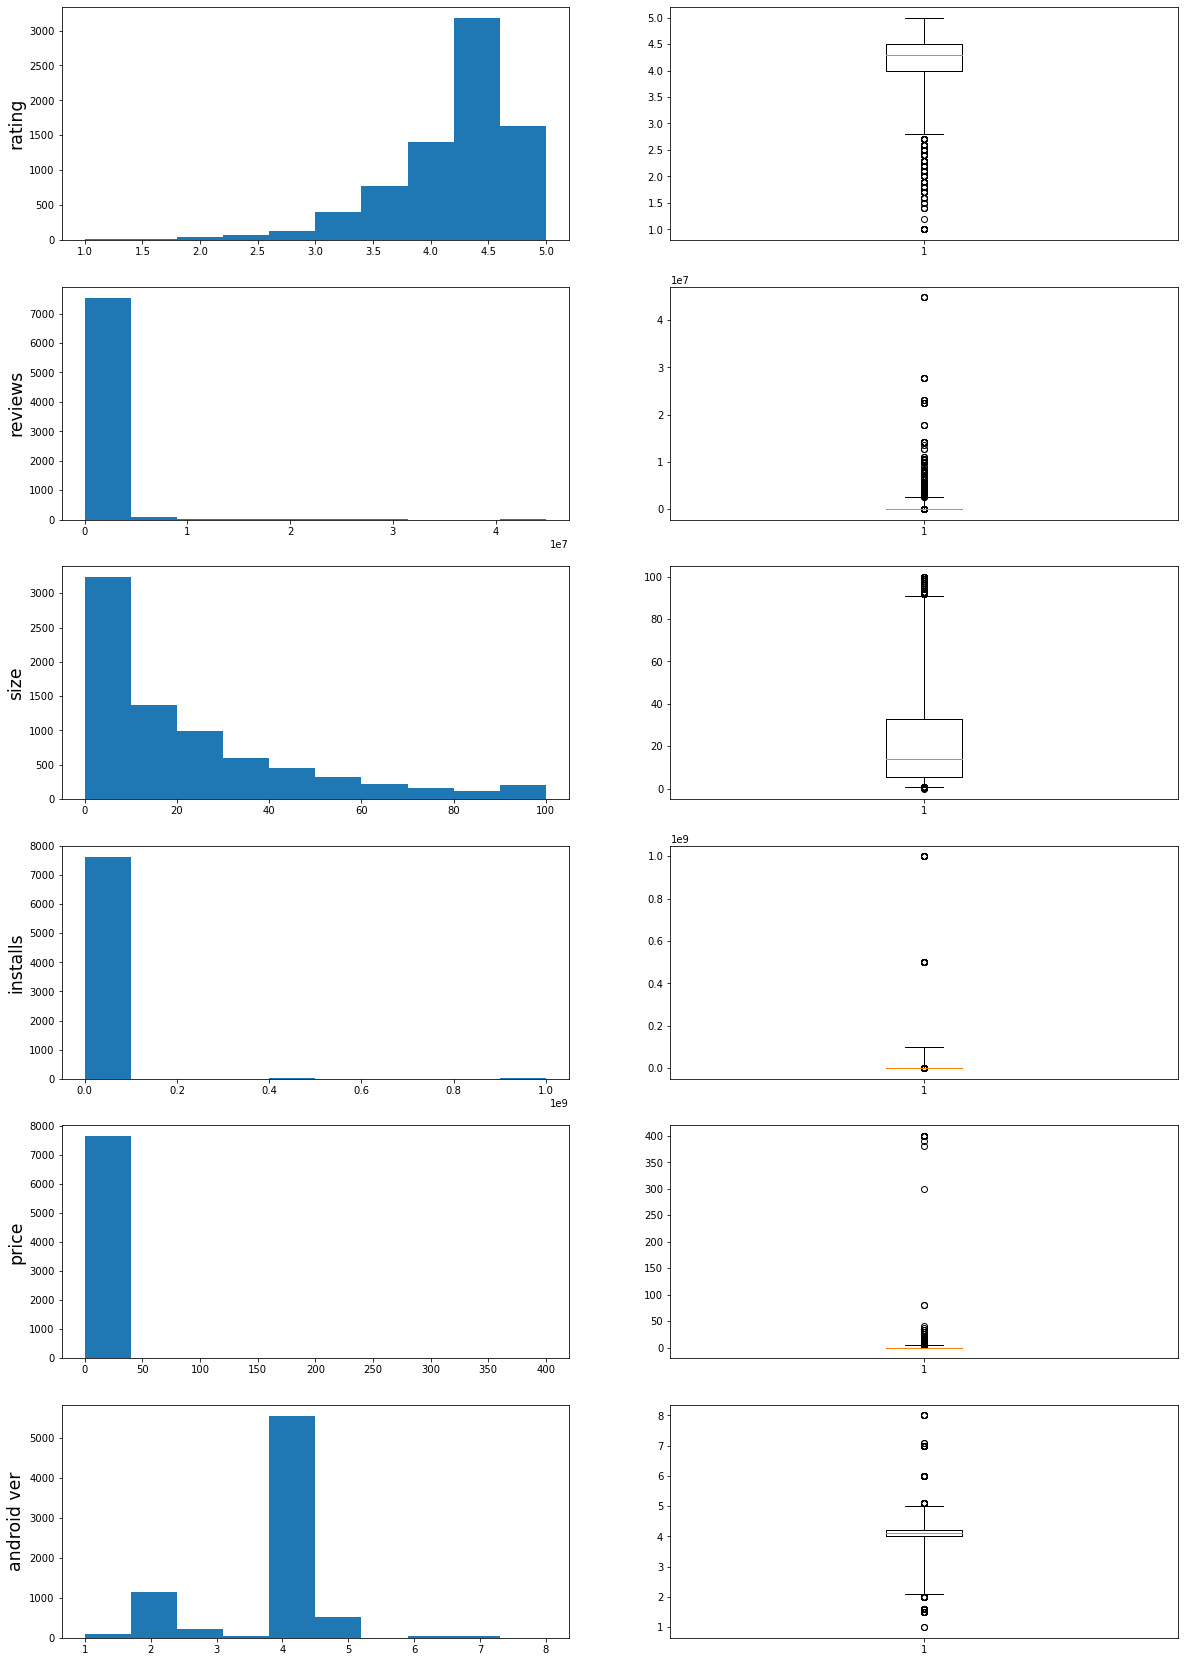

In [13]:
plot_hist_boxplot(df.select_dtypes(include='number'))

In [15]:
df.shape

(7667, 13)

In [ ]:
# Free of Paid could be a good ground truth to compare clustering results to
df['type'].unique()

<AxesSubplot:>

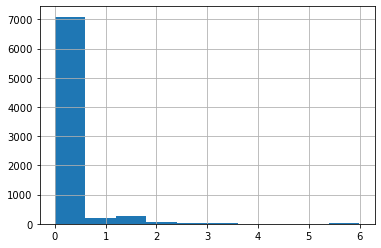

In [18]:
np.log(df['price'] + 1 ).hist()

In [36]:
X = df.select_dtypes(include='number').copy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

## K-means
Assumptions
- K clusters in the data
- clusters are isotropic
- similar variance

In [40]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=2, random_state=4123, n_init=1000, max_iter=1000)

# Fit model
kmeans_cluster.fit(X)
preds = kmeans_cluster.predict(X)

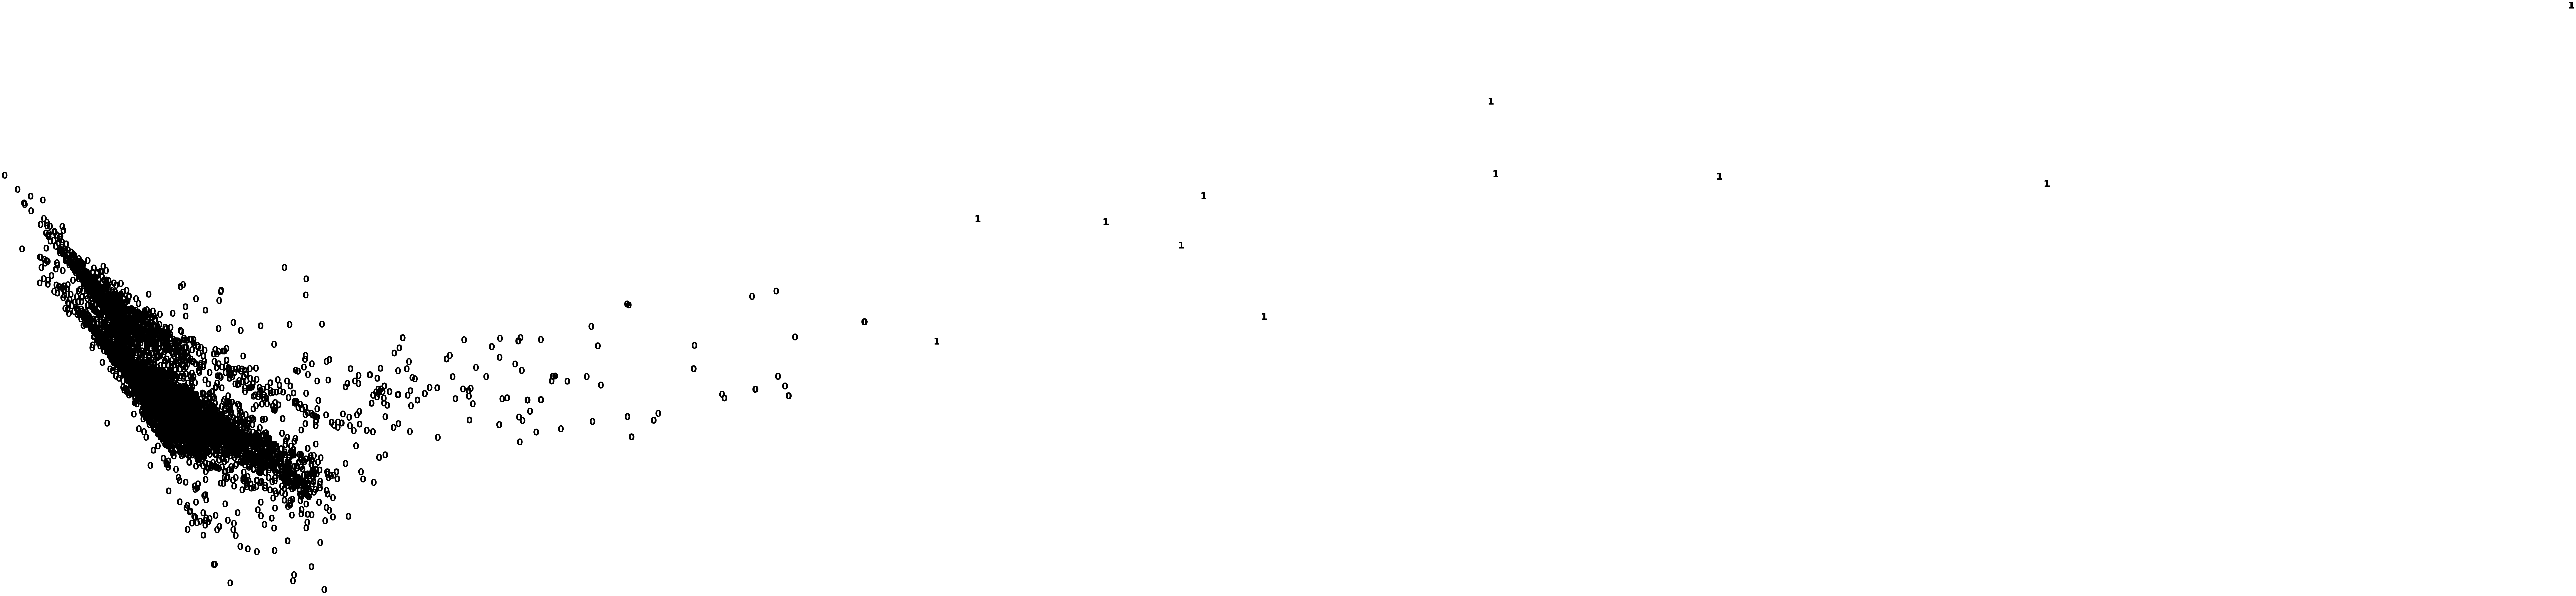

In [42]:
pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(preds[i]),
             # color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## Hierarchical
Assumptions and Considerations
- Linkage Method tuned to cluster shapes/composition


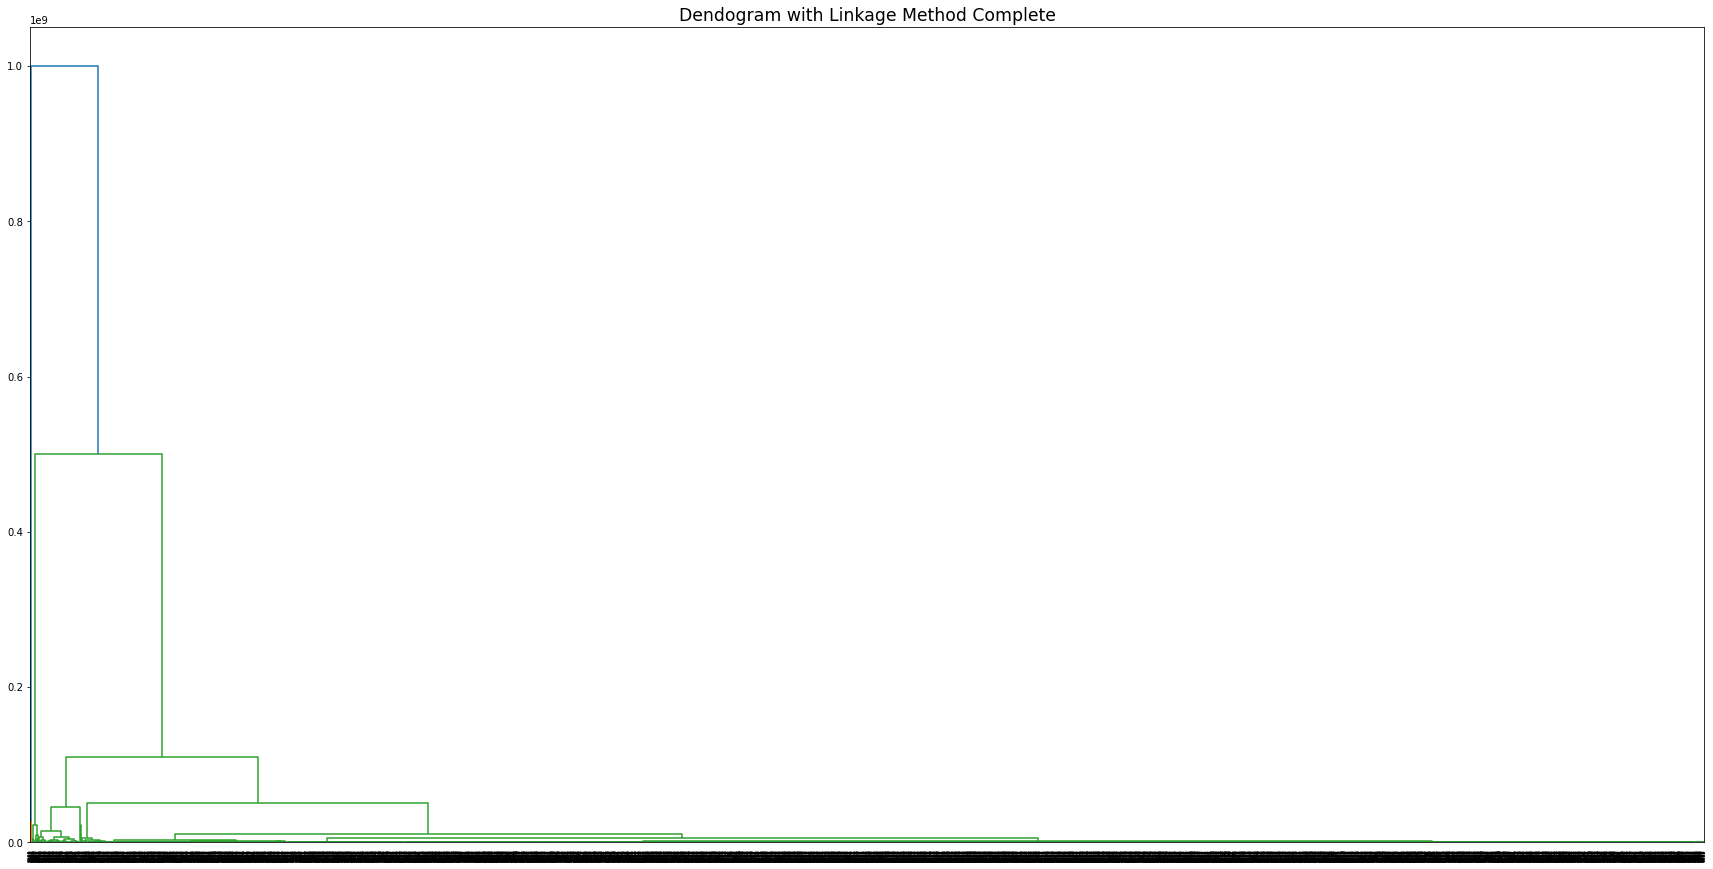

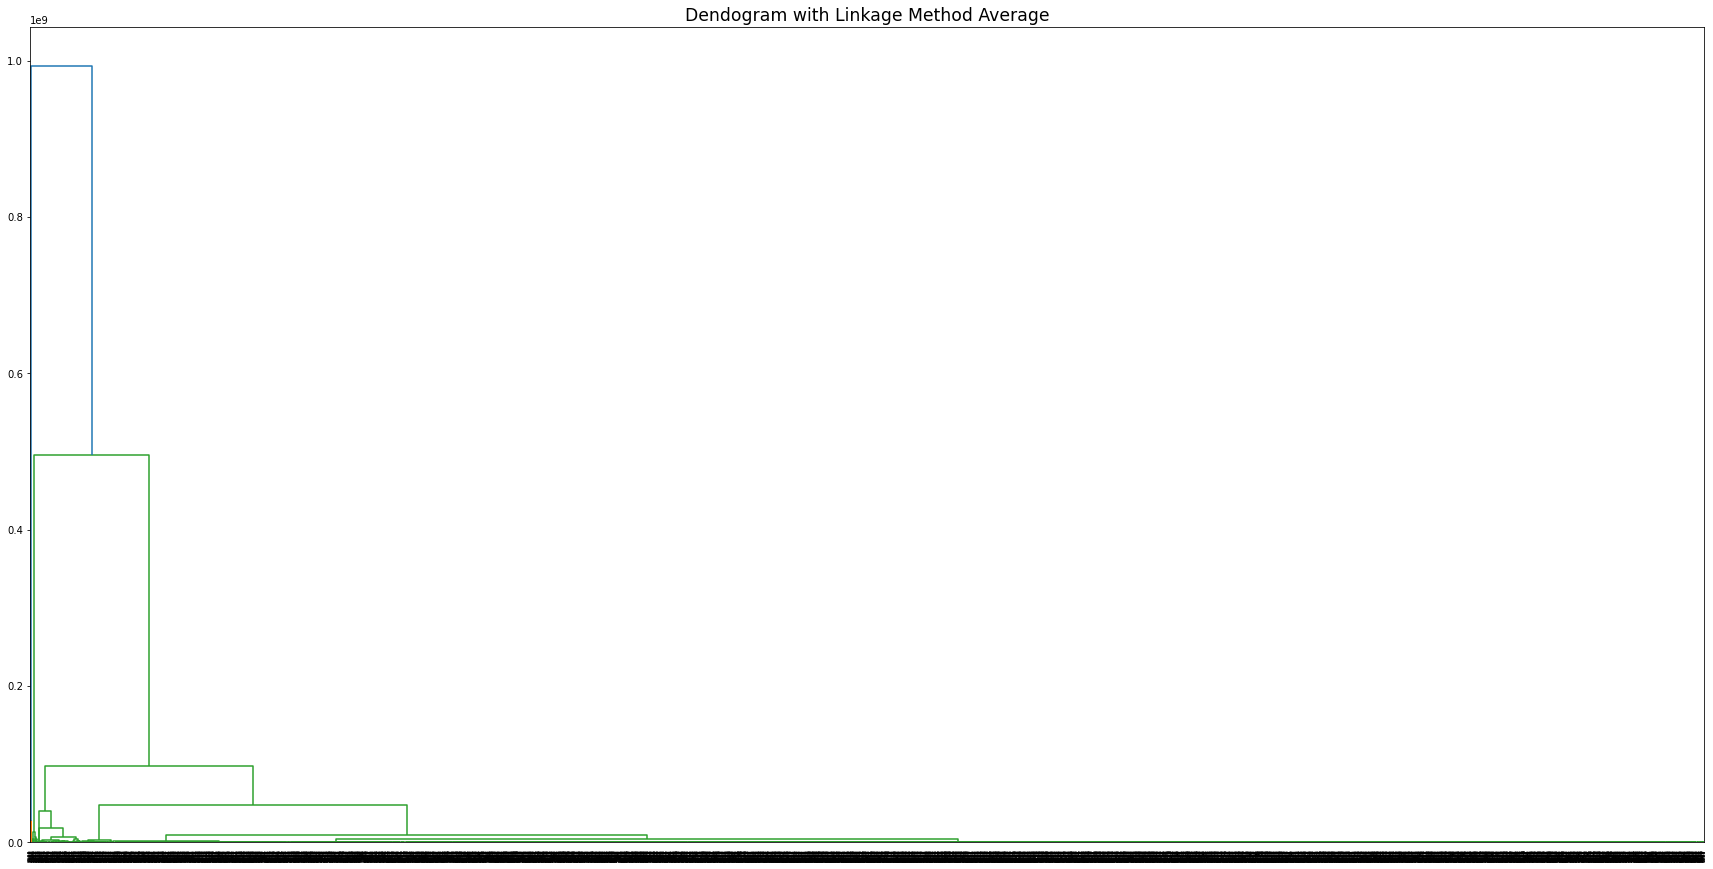

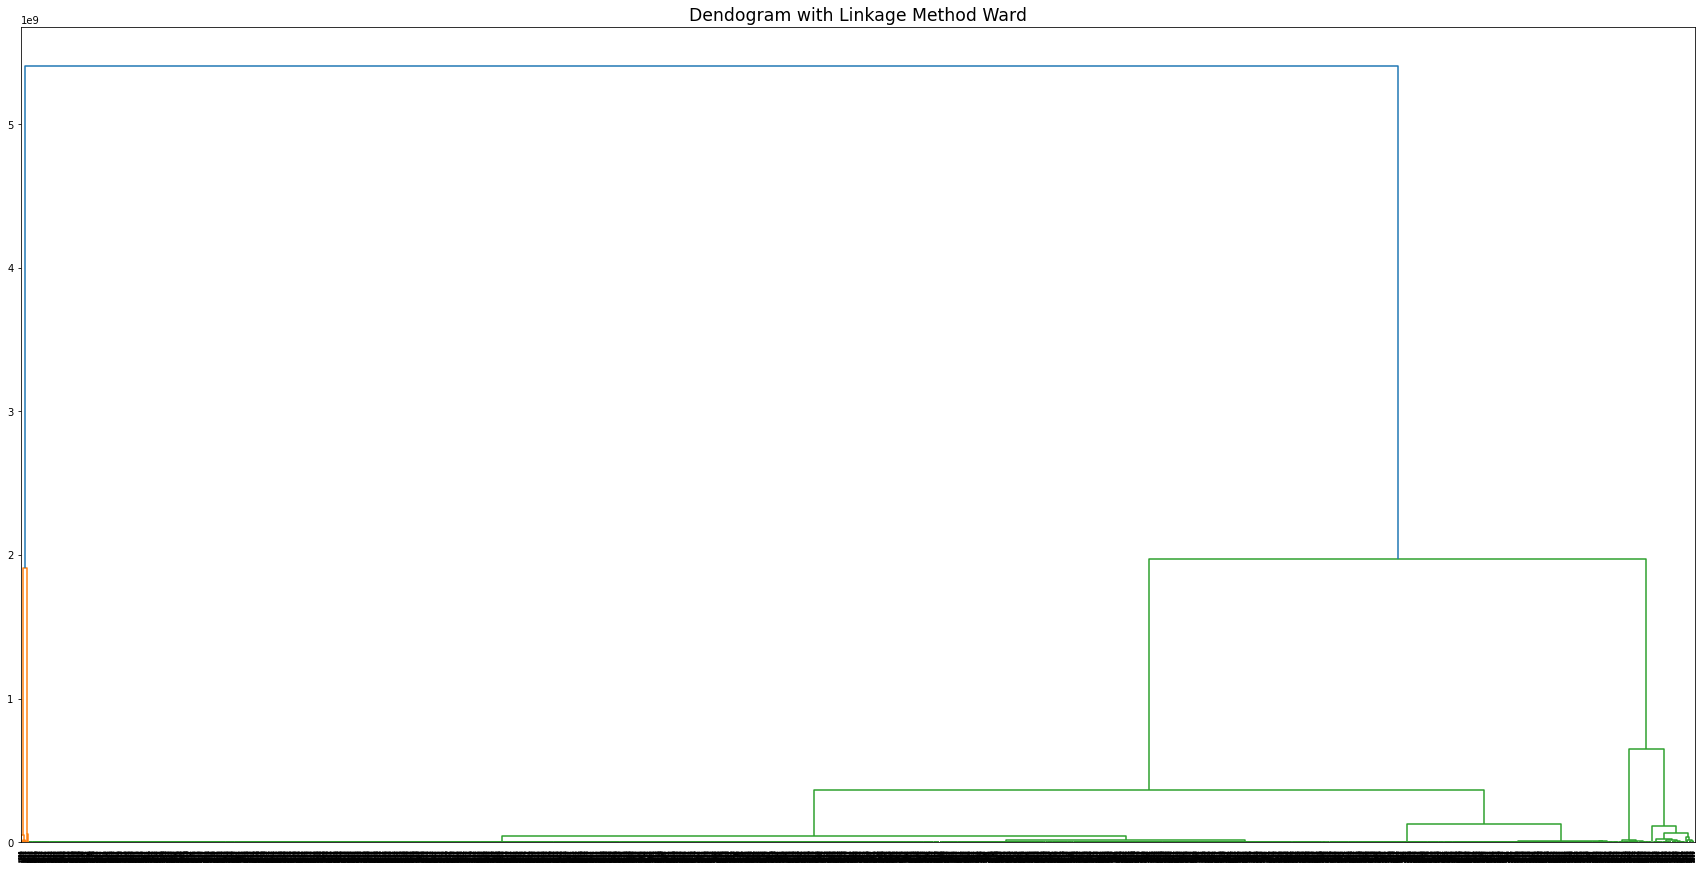

In [20]:
linkages = ['complete', 'average', 'ward']

for method in linkages:
    plt.figure(figsize=(30,15))
    plt.title('Dendogram with Linkage Method {}'.format(method.capitalize())
              , size='xx-large')
    dendrogram(linkage(X, method=method))
    plt.show()

## DBSCAN
Assumptions and Considerations
- no need to supply a number of clusters
- one of the fastest methods
- true clusters must be linearly separable 

In [39]:
# Defining the algorithm
dbscan_cluster = DBSCAN(eps=4, min_samples=20)

# Fit model
clusters = dbscan_cluster.fit_predict(X)

In [27]:
clusters.shape

(7667,)

In [38]:
np.unique(clusters)

array([-1])

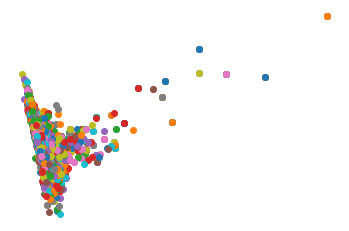

In [37]:
pca = PCA(n_components=2).fit_transform(X)

#plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.scatter(pca[i, 0], pca[i, 1],
             #color=colours[y[i]],
             #fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## GMM
- distributions must be gaussian
- soft clustering algorithm
- must supply K

## Dimensionality Reduction